In [37]:
from pyforest import *
import pandas as pd
import pandas_profiling

In [38]:
%time df = pd.read_csv('train_small.csv')
df.head()

CPU times: user 12.9 s, sys: 2.17 s, total: 15.1 s
Wall time: 15.7 s


,search_id,timestamp,site_id,user_country_id,user_hist_stars,user_hist_paid,listing_country_id,listing_id,listing_stars,listing_review_score,...,competitor6_price_percent_diff,competitor7_rate,competitor7_has_availability,competitor7_price_percent_diff,competitor8_rate,competitor8_has_availability,competitor8_price_percent_diff,clicked,booking_value,booked
0,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,3625,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,11622,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,11826,5,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,22824,3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,37581,5,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


### Shape of data

In [39]:
df.shape

(2380557, 54)

### View all the column names

In [4]:
for i in df.columns:
    print(i)

search_id
timestamp
site_id
user_country_id
user_hist_stars
user_hist_paid
listing_country_id
listing_id
listing_stars
listing_review_score
is_brand
location_score1
location_score2
log_historical_price
listing_position
price_usd
has_promotion
destination_id
length_of_stay
booking_window
num_adults
num_kids
num_rooms
stay_on_saturday
log_click_proportion
distance_to_dest
random_sort
competitor1_rate
competitor1_has_availability
competitor1_price_percent_diff
competitor2_rate
competitor2_has_availability
competitor2_price_percent_diff
competitor3_rate
competitor3_has_availability
competitor3_price_percent_diff
competitor4_rate
competitor4_has_availability
competitor4_price_percent_diff
competitor5_rate
competitor5_has_availability
competitor5_price_percent_diff
competitor6_rate
competitor6_has_availability
competitor6_price_percent_diff
competitor7_rate
competitor7_has_availability
competitor7_price_percent_diff
competitor8_rate
competitor8_has_availability
competitor8_price_percent_diff

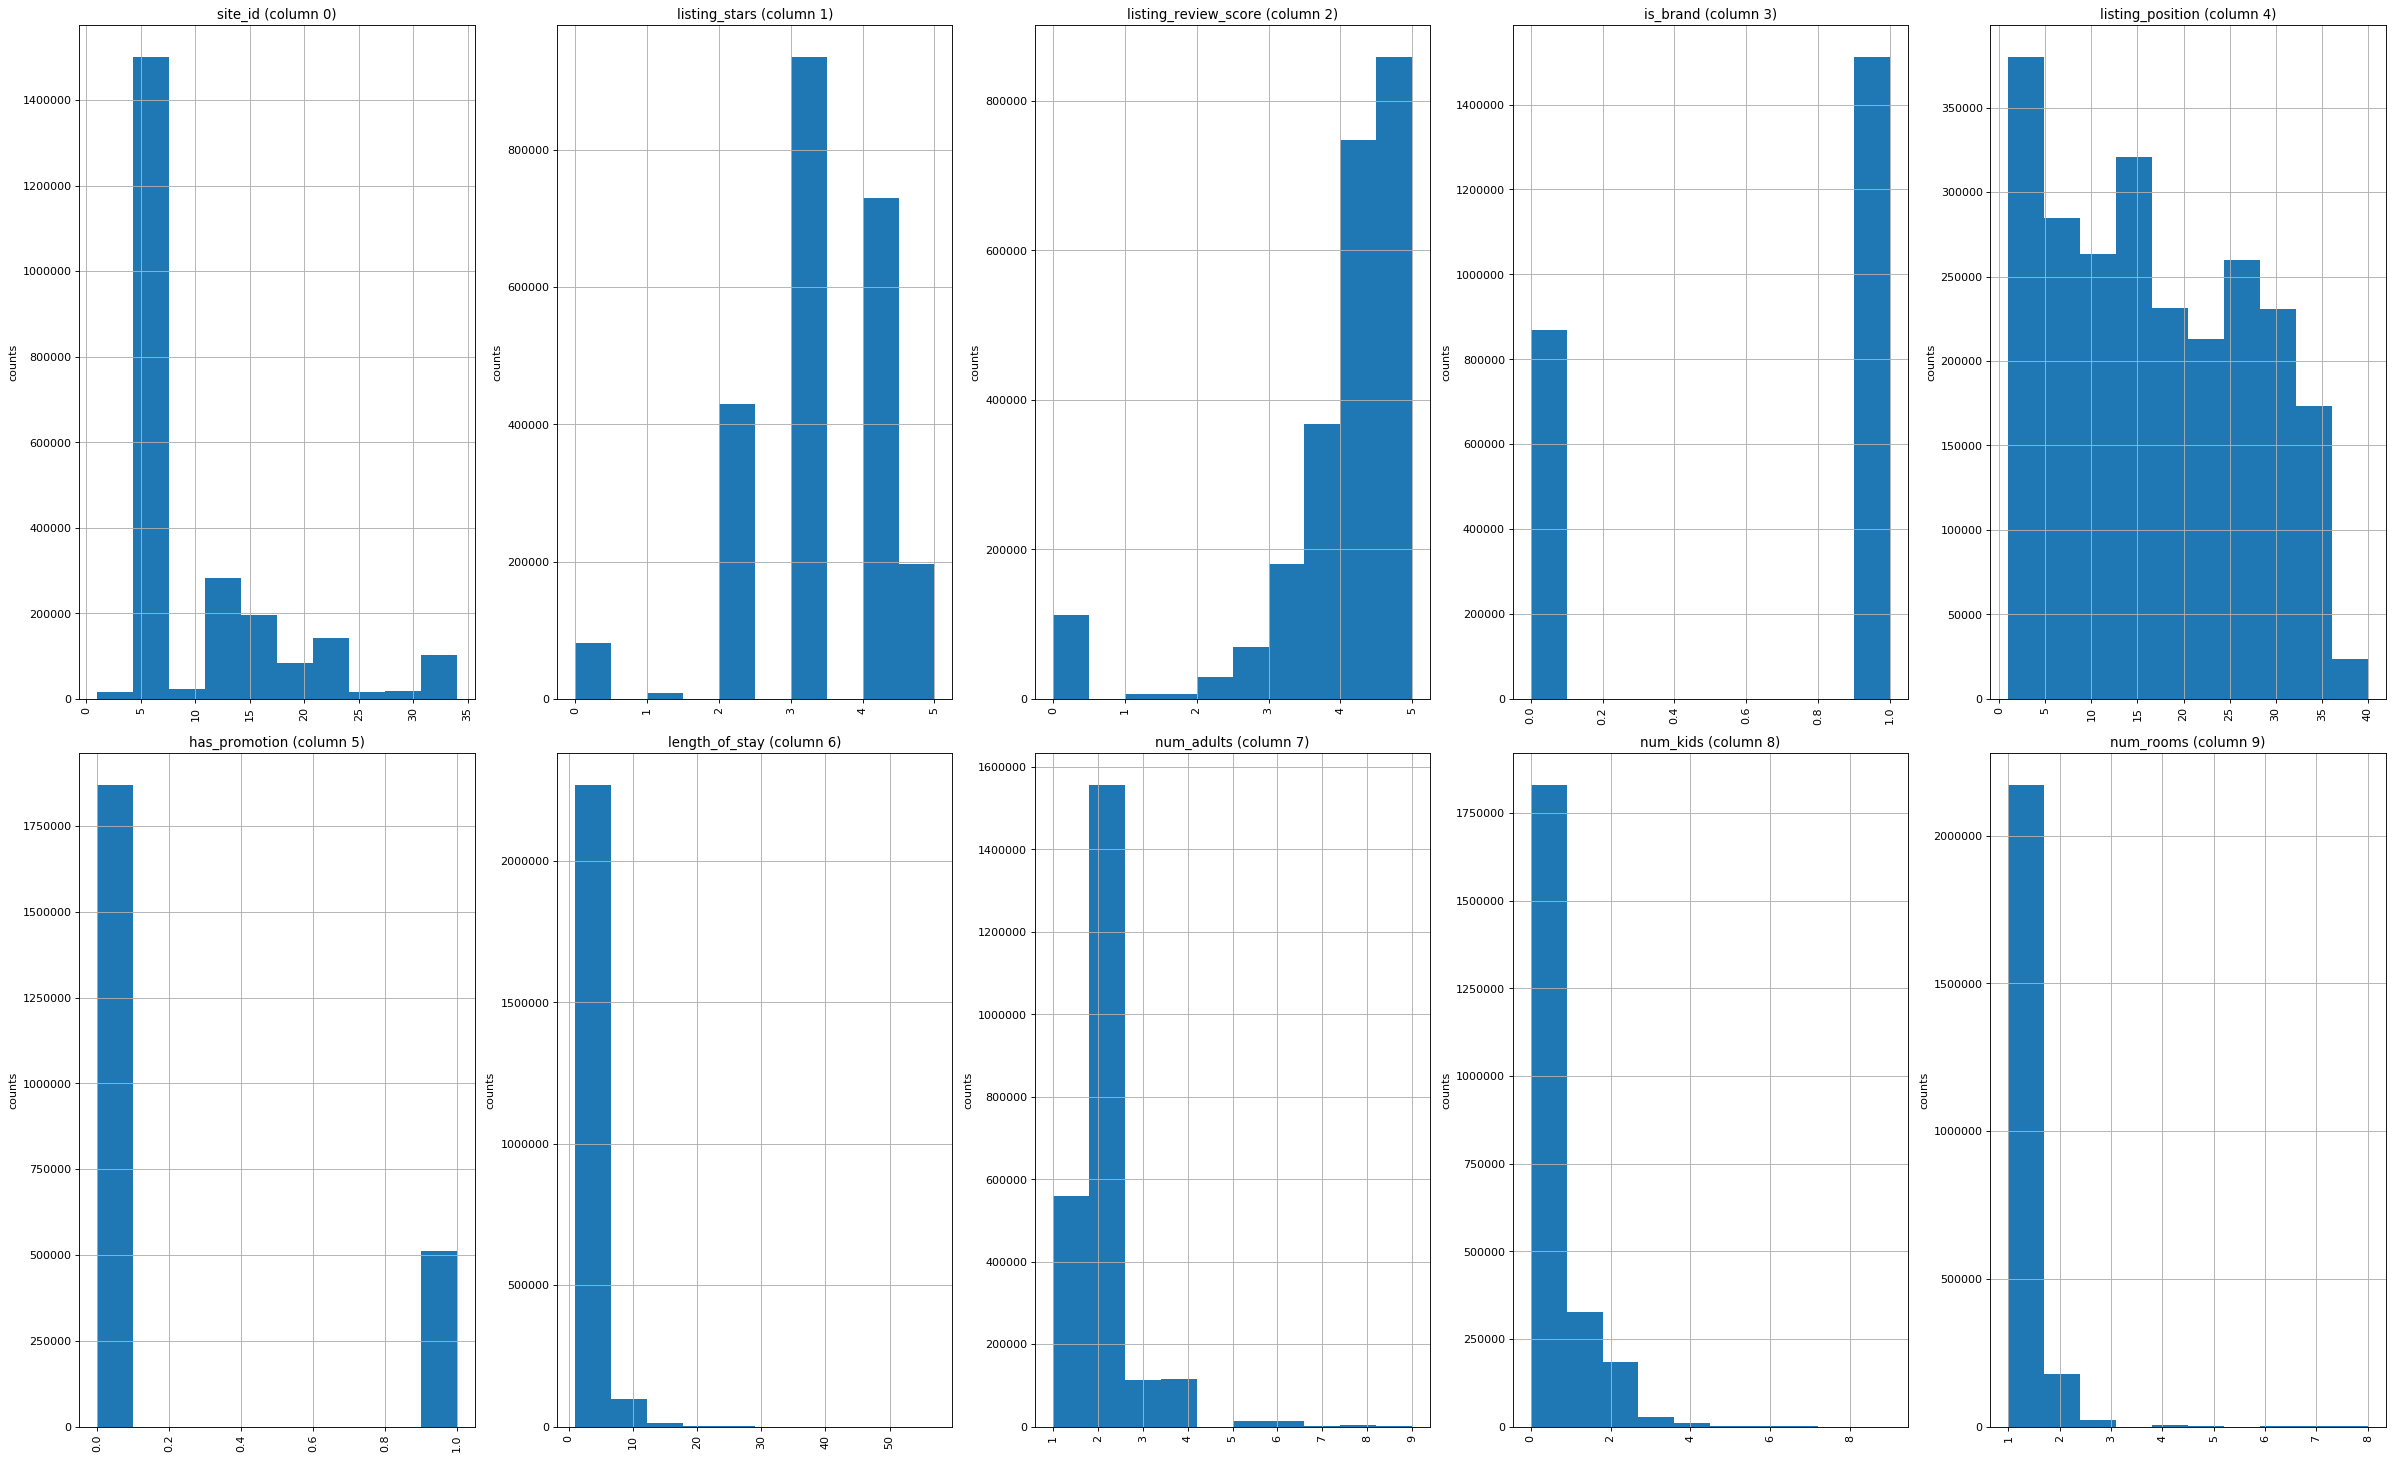

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
plotPerColumnDistribution(df, 10, 5)

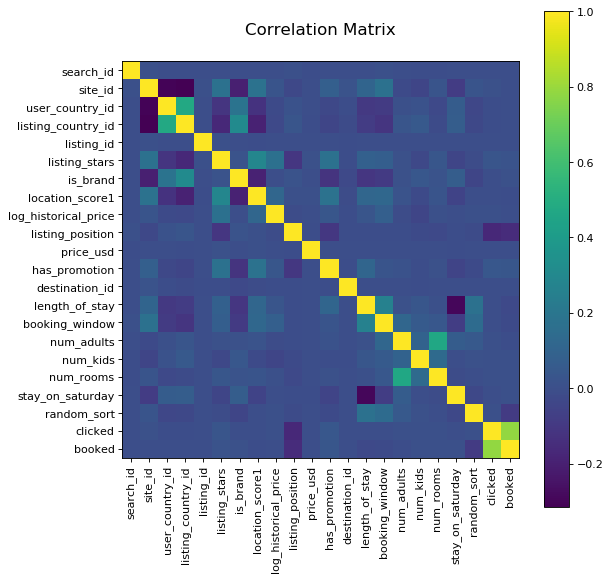

In [9]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

plotCorrelationMatrix(df, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380557 entries, 0 to 2380556
Data columns (total 54 columns):
search_id                         int64
timestamp                         object
site_id                           int64
user_country_id                   int64
user_hist_stars                   float64
user_hist_paid                    float64
listing_country_id                int64
listing_id                        int64
listing_stars                     int64
listing_review_score              float64
is_brand                          int64
location_score1                   float64
location_score2                   float64
log_historical_price              float64
listing_position                  int64
price_usd                         float64
has_promotion                     int64
destination_id                    int64
length_of_stay                    int64
booking_window                    int64
num_adults                        int64
num_kids                        

Our data contains 35 float features, 19 integer features and 1 object.

### categorical variables

In [7]:
%time temp_ser = df.nunique()
temp_ser[temp_ser<41].sort_values(ascending=False)

CPU times: user 17.8 ms, sys: 4.6 ms, total: 22.4 ms
Wall time: 21.4 ms


listing_position                40
site_id                         34
length_of_stay                  33
listing_review_score            10
num_kids                        10
num_adults                       9
num_rooms                        8
listing_stars                    6
competitor8_rate                 3
competitor8_has_availability     3
competitor4_rate                 3
competitor7_has_availability     3
competitor7_rate                 3
competitor6_has_availability     3
competitor6_rate                 3
competitor5_has_availability     3
competitor5_rate                 3
competitor4_has_availability     3
competitor2_has_availability     3
competitor3_has_availability     3
competitor3_rate                 3
competitor2_rate                 3
competitor1_has_availability     3
competitor1_rate                 3
random_sort                      2
stay_on_saturday                 2
has_promotion                    2
is_brand                         2
clicked             

### Continuous variables

In [8]:
temp_ser[temp_ser>41].sort_values(ascending=False)

distance_to_dest                  386387
listing_id                        117378
log_click_proportion              116185
search_id                          95842
timestamp                          95578
price_usd                          62712
booking_value                      39587
destination_id                     13122
location_score2                     9082
user_hist_paid                      4345
competitor1_price_percent_diff      1091
competitor5_price_percent_diff       494
competitor7_price_percent_diff       478
competitor2_price_percent_diff       467
competitor3_price_percent_diff       441
booking_window                       392
log_historical_price                 381
competitor8_price_percent_diff       377
competitor4_price_percent_diff       375
location_score1                      337
competitor6_price_percent_diff       300
user_hist_stars                      292
user_country_id                      192
listing_country_id                   166
dtype: int64

In [9]:
cat_list = temp_ser[temp_ser<41].index
cont_list = temp_ser[temp_ser>41].index

In [10]:
temp_arr = temp_ser.index
temp_arr[:4]

Index(['search_id', 'timestamp', 'site_id', 'user_country_id'], dtype='object')

### Converting all categorical variables

In [11]:
for i in cat_list:
    df[i] = df[i].astype('category')

In [12]:
#Number of categorical variables
print(len(cat_list))
print(len(cont_list))

30
24


#### Hence, the data has 31 categorical variables and 24 continuous variables

## Question b) -> Summary statistics and explain what issues do they reveal?

In [12]:
df.describe()

,search_id,site_id,user_country_id,user_hist_stars,user_hist_paid,listing_country_id,listing_id,listing_stars,listing_review_score,is_brand,...,competitor6_price_percent_diff,competitor7_rate,competitor7_has_availability,competitor7_price_percent_diff,competitor8_rate,competitor8_has_availability,competitor8_price_percent_diff,clicked,booking_value,booked
count,2.380557e+06,2.380557e+06,2.380557e+06,122780.000000,123494.000000,2.380557e+06,2.380557e+06,2.380557e+06,2.377071e+06,2.380557e+06,...,47961.000000,154468.000000,174850.000000,67832.000000,913495.000000,947465.000000,292700.000000,2.380557e+06,66388.000000,2.380557e+06
mean,3.337016e+05,9.970224e+00,1.754588e+02,3.382814,178.094940,1.739159e+02,7.008190e+04,3.180607e+00,3.779416e+00,6.346880e-01,...,17.196243,0.147856,0.083180,20.109919,-0.060010,0.009595,21.731093,4.456688e-02,383.229069,2.788759e-02
std,1.923719e+05,7.667827e+00,6.585934e+01,0.694562,108.568025,6.832483e+01,4.060398e+04,1.052086e+00,1.049727e+00,4.815176e-01,...,29.536009,0.579293,0.317575,63.110961,0.469455,0.203876,800.608005,2.063509e-01,527.019882,1.646508e-01
min,4.000000e+00,1.000000e+00,1.000000e+00,1.500000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000,-1.000000,-1.000000,2.000000,-1.000000,-1.000000,2.000000,0.000000e+00,0.000000,0.000000e+00
25%,1.674260e+05,5.000000e+00,1.000000e+02,2.950000,111.090000,1.000000e+02,3.502800e+04,3.000000e+00,3.500000e+00,0.000000e+00,...,6.000000,0.000000,0.000000,7.000000,0.000000,0.000000,7.000000,0.000000e+00,124.150000,0.000000e+00
50%,3.332720e+05,5.000000e+00,2.190000e+02,3.450000,152.620000,2.190000e+02,6.961500e+04,3.000000e+00,4.000000e+00,1.000000e+00,...,11.000000,0.000000,0.000000,12.000000,0.000000,0.000000,11.000000,0.000000e+00,219.185000,0.000000e+00
75%,5.007050e+05,1.400000e+01,2.190000e+02,3.950000,215.950000,2.190000e+02,1.051420e+05,4.000000e+00,4.500000e+00,1.000000e+00,...,18.000000,1.000000,0.000000,20.000000,0.000000,0.000000,17.000000,0.000000e+00,432.125000,0.000000e+00
max,6.655730e+05,3.400000e+01,2.310000e+02,5.000000,1507.120000,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,...,1363.000000,1.000000,1.000000,7951.000000,1.000000,1.000000,130000.000000,1.000000e+00,20238.720000,1.000000e+00


- user_hist_stars, user_hist_paid, log_click_proportion, booking_value and mostly competitor data have null values more than 85% of data which can be dropped during model building time.
- user_hist_paid and booking_value have highly right skewed data and very highly dispersed data [needs more understanding of columns][May need to be cleaned].

In [13]:
(df.isnull().sum()/df.shape[0])*100

search_id                          0.000000
timestamp                          0.000000
site_id                            0.000000
user_country_id                    0.000000
user_hist_stars                   94.842384
user_hist_paid                    94.812391
listing_country_id                 0.000000
listing_id                         0.000000
listing_stars                      0.000000
listing_review_score               0.146436
is_brand                           0.000000
location_score1                    0.000000
location_score2                   22.095333
log_historical_price               0.000000
listing_position                   0.000000
price_usd                          0.000000
has_promotion                      0.000000
destination_id                     0.000000
length_of_stay                     0.000000
booking_window                     0.000000
num_adults                         0.000000
num_kids                           0.000000
num_rooms                       

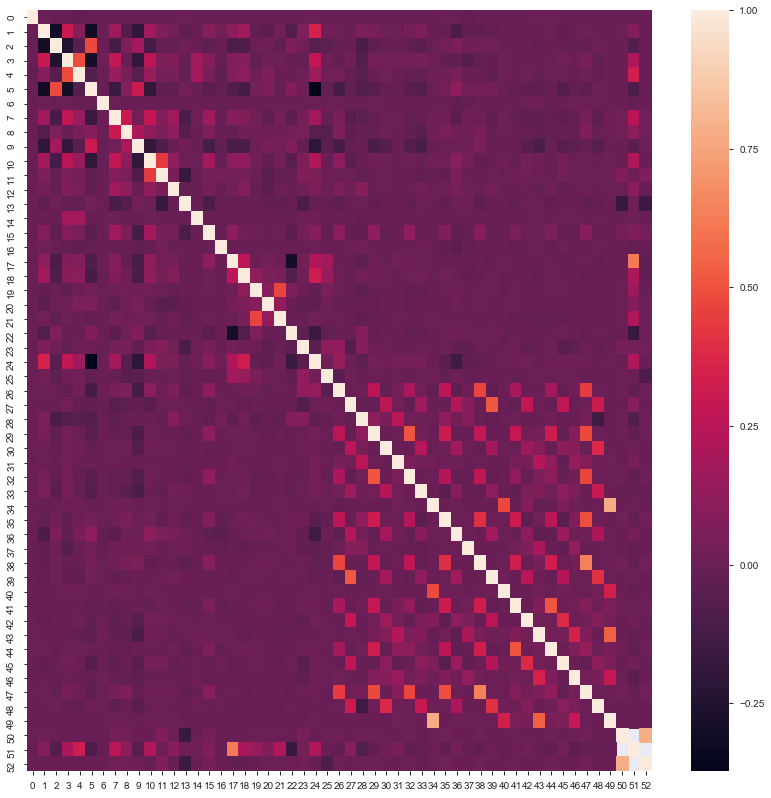

In [17]:
plt.subplots(figsize=(14,14))
sns.heatmap(df.corr())
plt.show()

In [18]:
pd.Series(df.columns)

0                          search_id
1                          timestamp
2                            site_id
3                    user_country_id
4                    user_hist_stars
5                     user_hist_paid
6                 listing_country_id
7                         listing_id
8                      listing_stars
9               listing_review_score
10                          is_brand
11                   location_score1
12                   location_score2
13              log_historical_price
14                  listing_position
15                         price_usd
16                     has_promotion
17                    destination_id
18                    length_of_stay
19                    booking_window
20                        num_adults
21                          num_kids
22                         num_rooms
23                  stay_on_saturday
24              log_click_proportion
25                  distance_to_dest
26                       random_sort
2

In [22]:
df.iloc[:,51:].corr()

,clicked,booking_value,booked
clicked,1.000000,NaN,0.784226
booking_value,NaN,1.0,NaN
booked,0.784226,NaN,1.000000


In [24]:
df[['competitor4_price_percent_diff','competitor7_price_percent_diff']].corr()

,competitor4_price_percent_diff,competitor7_price_percent_diff
competitor4_price_percent_diff,1.00000,0.13431
competitor7_price_percent_diff,0.13431,1.00000


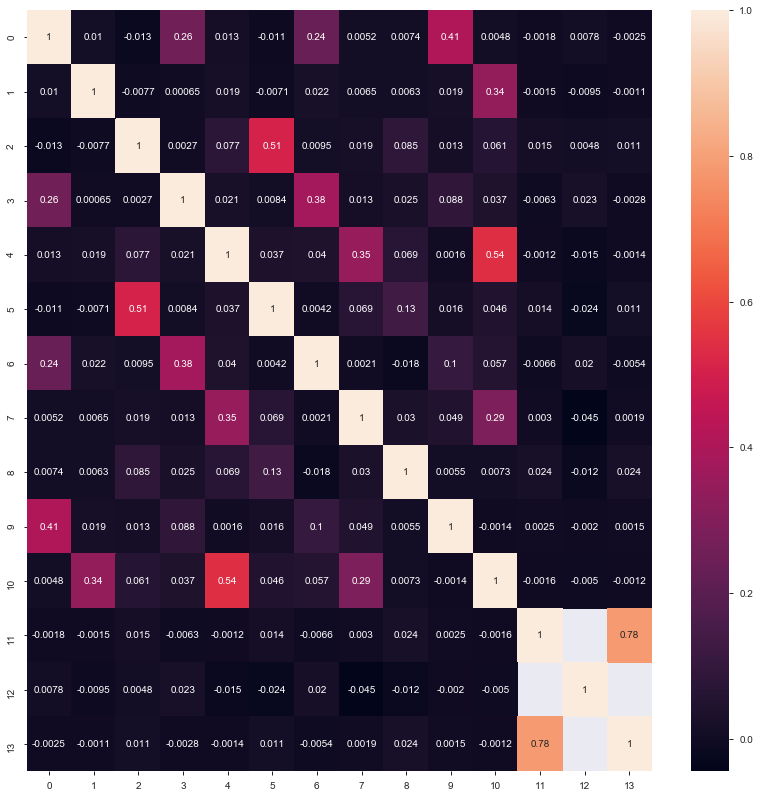

In [30]:
plt.subplots(figsize=(14,14))
sns.heatmap(df.iloc[:,40:].corr(),annot=True)
plt.show()

Booked and clicked are 0.78 collinear but they are dependent on each other. Hence can not remove one of them.

## Booked and clicked are highly unbalanced and can generate false reduction in accuracy

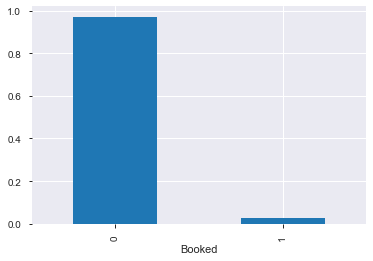

In [18]:
temp_ser = df['booked'].value_counts(normalize=True)
temp_ser.plot(kind='bar')
plt.xlabel('Booked')
plt.show()   

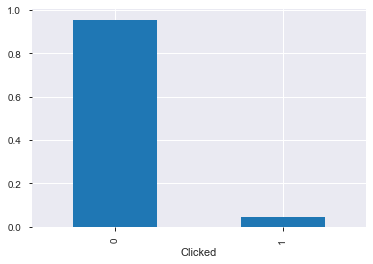

In [17]:
temp_ser = df['clicked'].value_counts(normalize=True)
temp_ser.plot(kind='bar')
plt.xlabel('Clicked')
plt.show()  

In [21]:
df['price_usd'].unique()

array([295.  , 299.  , 373.  , ..., 323.19, 522.29, 682.61])

In [53]:
df['num_rooms'].unique()

array([1, 2, 3, 4, 5, 8, 6, 7])

## Creating total number of travellers 

In [41]:
df['num_total'] = df['num_adults']+df['num_kids']

## Now cleaning price_usd
- can be price per night
- can be price for whole stay
- depending on the country and hotels convention

In [68]:
df[(df['listing_stars']==0)&(df['num_rooms']==1)][(df['length_of_stay']==1)][['price_usd','listing_stars','length_of_stay']].describe()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,price_usd,listing_stars,length_of_stay
count,37861.000000,37861.0,37861.0
mean,125.365853,0.0,1.0
std,491.720498,0.0,0.0
min,0.500000,0.0,1.0
25%,70.000000,0.0,1.0
50%,96.000000,0.0,1.0
75%,139.000000,0.0,1.0
max,90928.000000,0.0,1.0


## Getting maximum permissible value for each listing stars to separate full length payments in price_usd

In [70]:
temp = df[(df['listing_stars']==0)&(df['num_rooms']==1)][df['length_of_stay']==1][['price_usd','listing_stars','length_of_stay']]
temp.quantile(0.9)[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


205.44

In [72]:
temp = df[(df['listing_stars']==1)&(df['num_rooms']==1)][df['length_of_stay']==1][['price_usd','listing_stars','length_of_stay']]
temp.quantile(0.95)[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


157.02899999999985

In [73]:
temp = df[(df['listing_stars']==2)&(df['num_rooms']==1)][df['length_of_stay']==1][['price_usd','listing_stars','length_of_stay']]
temp.quantile(0.99)[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


226.24040000000036

In [74]:
temp = df[(df['listing_stars']==3)&(df['num_rooms']==1)][df['length_of_stay']==1][['price_usd','listing_stars','length_of_stay']]
temp.quantile(0.99)[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


309.4180000000028

In [75]:
temp = df[(df['listing_stars']==4)&(df['num_rooms']==1)][df['length_of_stay']==1][['price_usd','listing_stars','length_of_stay']]
temp.quantile(0.95)[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


349.0

In [76]:
temp = df[(df['listing_stars']==5)&(df['num_rooms']==1)][df['length_of_stay']==1][['price_usd','listing_stars','length_of_stay']]
temp.quantile(0.95)[0]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


618.9654999999997

Creating a permissible maximum range for per room per day by getting the quantile value of that particular data.

Values which are lower than this value will be continued on with the modelling. 

In [78]:
df_add1 = df[(df['listing_stars']==0)&(df['num_rooms']==1)][(df['price_usd']<205.44)&(df['length_of_stay']==1)]
df_add2 = df[(df['listing_stars']==1)&(df['num_rooms']==1)][(df['price_usd']<157.03)&(df['length_of_stay']==1)]
df_add3 = df[(df['listing_stars']==2)&(df['num_rooms']==1)][(df['price_usd']<226.24)&(df['length_of_stay']==1)]
df_add4 = df[(df['listing_stars']==3)&(df['num_rooms']==1)][(df['price_usd']<309.18)&(df['length_of_stay']==1)]
df_add5 = df[(df['listing_stars']==4)&(df['num_rooms']==1)][(df['price_usd']<349)&(df['length_of_stay']==1)]
df_add6 = df[(df['listing_stars']==5)&(df['num_rooms']==1)][(df['price_usd']<618.97)&(df['length_of_stay']==1)]
df_add = pd.concat([df_add1,df_add2,df_add3,df_add4,df_add5,df_add6])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed

## Cleaned length_of_stay = 1

In [79]:
df_add.shape

(919090, 55)

In [80]:
df_add['price_usd_corr'] = df_add['price_usd']

To remove the price_usd anonimity that the prices are per night or per length of stay. Follow this algorithm

In [81]:
temp1 = df[(((df['price_usd']/df['num_rooms'])/df['length_of_stay'])<205.44)&(df['listing_stars']==0)&(df['length_of_stay']>1)]
temp1['price_usd_corr'] = ((temp1[(temp1['price_usd']>=205.44)]['price_usd'])/(temp1[(temp1['price_usd']>=205.44)]['length_of_stay']))/(temp1[(temp1['price_usd']>=205.44)]['num_rooms'])
temp1['price_usd_corr'] = np.where(temp1['price_usd_corr'].isnull(),temp1['price_usd'],temp1['price_usd_corr'])

temp2 = df[(((df['price_usd']/df['num_rooms'])/df['length_of_stay'])<157.03)&(df['listing_stars']==1)&(df['length_of_stay']>1)]
temp2['price_usd_corr'] = ((temp2[(temp2['price_usd']>=157.03)]['price_usd'])/(temp2[(temp2['price_usd']>=157.03)]['length_of_stay']))/(temp1[(temp1['price_usd']>=157.03)]['num_rooms'])
temp2['price_usd_corr'] = np.where(temp2['price_usd_corr'].isnull(),temp2['price_usd'],temp2['price_usd_corr'])

temp3 = df[(((df['price_usd']/df['num_rooms'])/df['length_of_stay'])<226.24)&(df['listing_stars']==2)&(df['length_of_stay']>1)]
temp3['price_usd_corr'] = ((temp3[(temp3['price_usd']>=226.24)]['price_usd'])/(temp3[(temp3['price_usd']>=226.24)]['length_of_stay']))/(temp1[(temp1['price_usd']>=226.24)]['num_rooms'])
temp3['price_usd_corr'] = np.where(temp3['price_usd_corr'].isnull(),temp3['price_usd'],temp3['price_usd_corr'])

temp4 = df[(((df['price_usd']/df['num_rooms'])/df['length_of_stay'])<309.18)&(df['listing_stars']==3)&(df['length_of_stay']>1)]
temp4['price_usd_corr'] = ((temp4[(temp4['price_usd']>=309.18)]['price_usd'])/(temp4[(temp4['price_usd']>=309.18)]['length_of_stay']))/(temp1[(temp1['price_usd']>=309.18)]['num_rooms'])
temp4['price_usd_corr'] = np.where(temp4['price_usd_corr'].isnull(),temp4['price_usd'],temp4['price_usd_corr'])

temp5 = df[(((df['price_usd']/df['num_rooms'])/df['length_of_stay'])<349)&(df['listing_stars']==4)&(df['length_of_stay']>1)]
temp5['price_usd_corr'] = ((temp5[(temp5['price_usd']>=349)]['price_usd'])/(temp5[(temp5['price_usd']>=349)]['length_of_stay']))/(temp1[(temp1['price_usd']>=349)]['num_rooms'])
temp5['price_usd_corr'] = np.where(temp5['price_usd_corr'].isnull(),temp5['price_usd'],temp5['price_usd_corr'])

temp6 = df[(((df['price_usd']/df['num_rooms'])/df['length_of_stay'])<618.97)&(df['listing_stars']==5)&(df['length_of_stay']>1)]
temp6['price_usd_corr'] = ((temp6[(temp6['price_usd']>=618.97)]['price_usd'])/(temp6[(temp6['price_usd']>=618.97)]['length_of_stay']))/(temp1[(temp1['price_usd']>=618.97)]['num_rooms'])
temp6['price_usd_corr'] = np.where(temp6['price_usd_corr'].isnull(),temp6['price_usd'],temp6['price_usd_corr'])

df_addd = pd.concat([temp1,temp2,temp3,temp4,temp5,temp6])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [82]:
df_addd[['price_usd','price_usd_corr']].describe()

,price_usd,price_usd_corr
count,1.347718e+06,1.347718e+06
mean,1.651119e+02,1.640185e+02
std,1.250035e+02,1.244063e+02
min,0.000000e+00,0.000000e+00
25%,8.956000e+01,8.900000e+01
50%,1.320000e+02,1.310000e+02
75%,2.007600e+02,1.990000e+02
max,7.276880e+03,7.276880e+03


In [83]:
df_cleaned = pd.concat([df_add,df_addd])

In [84]:
df_cleaned.shape

(2266808, 56)

## Created a new column is_converted to see who converted [check conversion ratio]

In [89]:
d1 = df_cleaned[(df_cleaned['clicked']==1)&(df_cleaned['booked']==1)]
d1['is_converted'] = df_cleaned[(df_cleaned['clicked']==1)&(df_cleaned['booked']==1)]['booked']

d2 = df_cleaned[(df_cleaned['clicked']==1)&(df_cleaned['booked']==0)]
d2['is_converted'] = df_cleaned[(df_cleaned['clicked']==1)&(df_cleaned['booked']==0)]['booked']

d3 = df_cleaned[df_cleaned['clicked']==0]
d3['is_converted'] = np.nan

df_cleaned = pd.concat([d1,d2,d3])
df_cleaned.shape

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

(2266808, 57)

# Conversion ratio

In [154]:
t = df_cleaned[df_cleaned['clicked']==1]['search_id'].unique()
temp = df_cleaned[df_cleaned['is_converted']==0]['search_id'].unique()
tmp = df_cleaned[df_cleaned['is_converted']==1]['search_id'].unique()

In [155]:
lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)

In [156]:
print('total_users_clicked',len(t))
print('not_converted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))

total_users_clicked 91352
not_converted_users_including_some_converted_users 32322
converted_users 62881


In [8]:
62881/df_cleaned.shape[0]

0.02773988798345515

# Click through rate

In [2]:
df_cleaned = pd.read_csv('df_cleaned.csv')

In [3]:
temp = df_cleaned[(df_cleaned['clicked']==0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['clicked']==1)]['search_id'].unique()

In [4]:
lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)

In [5]:
print('not_clicked_users_including_some_clicked_users',len(temp))
print('clicked_users',len(tmp))

not_clicked_users_including_some_clicked_users 91734
clicked_users 91352


In [7]:
len(tmp)/df_cleaned.shape[0]*100

4.029984012761558

In [167]:
df_cleaned[['competitor1_rate','competitor1_has_availability','competitor1_price_percent_diff', 'competitor2_rate','competitor2_has_availability', 'competitor2_price_percent_diff','competitor3_rate', 'competitor3_has_availability','competitor3_price_percent_diff', 'competitor4_rate', 'competitor4_has_availability', 'competitor4_price_percent_diff', 'competitor5_rate', 'competitor5_has_availability','competitor5_price_percent_diff', 'competitor6_rate','competitor6_has_availability', 'competitor6_price_percent_diff','competitor7_rate', 'competitor7_has_availability','competitor7_price_percent_diff', 'competitor8_rate', 'competitor8_has_availability', 'competitor8_price_percent_diff']].shape[0]

2266808

In [168]:
df_cleaned[['competitor1_rate','competitor1_has_availability','competitor1_price_percent_diff', 'competitor2_rate','competitor2_has_availability', 'competitor2_price_percent_diff','competitor3_rate', 'competitor3_has_availability','competitor3_price_percent_diff', 'competitor4_rate', 'competitor4_has_availability', 'competitor4_price_percent_diff', 'competitor5_rate', 'competitor5_has_availability','competitor5_price_percent_diff', 'competitor6_rate','competitor6_has_availability', 'competitor6_price_percent_diff','competitor7_rate', 'competitor7_has_availability','competitor7_price_percent_diff', 'competitor8_rate', 'competitor8_has_availability', 'competitor8_price_percent_diff']].dropna(how='all').shape[0]

1520973

In [170]:
df_cleaned[['competitor1_rate','competitor1_has_availability','competitor1_price_percent_diff', 'competitor2_rate','competitor2_has_availability', 'competitor2_price_percent_diff','competitor3_rate', 'competitor3_has_availability','competitor3_price_percent_diff', 'competitor4_rate', 'competitor4_has_availability', 'competitor4_price_percent_diff', 'competitor5_rate', 'competitor5_has_availability','competitor5_price_percent_diff', 'competitor6_rate','competitor6_has_availability', 'competitor6_price_percent_diff','competitor7_rate', 'competitor7_has_availability','competitor7_price_percent_diff', 'competitor8_rate', 'competitor8_has_availability', 'competitor8_price_percent_diff']].dropna(how='all')

,competitor1_rate,competitor1_has_availability,competitor1_price_percent_diff,competitor2_rate,competitor2_has_availability,competitor2_price_percent_diff,competitor3_rate,competitor3_has_availability,competitor3_price_percent_diff,competitor4_rate,...,competitor5_price_percent_diff,competitor6_rate,competitor6_has_availability,competitor6_price_percent_diff,competitor7_rate,competitor7_has_availability,competitor7_price_percent_diff,competitor8_rate,competitor8_has_availability,competitor8_price_percent_diff
3474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
11661,NaN,NaN,NaN,1.0,0.0,14.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,13.0
23793,NaN,NaN,NaN,1.0,0.0,11.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29800,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34307,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380450,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,0.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2380451,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2380455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2380457,NaN,NaN,NaN,1.0,0.0,4.0,NaN,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# For competitor 1 when there is availability and agency's price is same

In [234]:
temp = df_cleaned[(df_cleaned['competitor1_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor1_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor1_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor1_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 2624
converted_users 474
number of not converted people 2163
conversion rate 17.974971558589306


## Agency started selling cheaper rooms than compt 1, the conversion rate increased suggesting that the agency started giving promotion on those hotels which usually did't fluctuate much in the competitor 1 website.

In [235]:
temp = df_cleaned[(df_cleaned['competitor1_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor1_rate']==1.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor1_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor1_rate']==1.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 2949
converted_users 876
number of not converted people 2087
conversion rate 29.564630442119473


# For competitor 2 when there is availability and agency's price is same

In [221]:
temp = df_cleaned[(df_cleaned['competitor2_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor2_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor2_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor2_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 52380
converted_users 20249
number of not converted people 32291
conversion rate 38.54015987818805


# For competitor 3 when there is availability and agency's price is same

In [224]:
temp = df_cleaned[(df_cleaned['competitor3_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor3_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor3_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor3_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 39633
converted_users 15159
number of not converted people 24655
conversion rate 38.074546641884766


# For competitor 4 when there is availability and agency's price is same

In [227]:
temp = df_cleaned[(df_cleaned['competitor4_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor4_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor4_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor4_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 9465
converted_users 2640
number of not converted people 6875
conversion rate 27.74566473988439


# For competitor 5 when there is availability and agency's price is same

In [210]:
temp = df_cleaned[(df_cleaned['competitor5_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor5_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor5_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor5_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 57943
converted_users 20284
number of not converted people 37888
conversion rate 34.86900914529327


# For competitor 6 when there is availability and agency's price is same

In [233]:
temp = df_cleaned[(df_cleaned['competitor6_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor6_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor6_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor6_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 8768
converted_users 2304
number of not converted people 6508
conversion rate 26.14616432137994


# For competitor 7 when there is availability and agency's price is same

In [206]:
temp = df_cleaned[(df_cleaned['competitor7_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor7_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor7_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor7_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 10634
converted_users 2948
number of not converted people 7749
conversion rate 27.55912872768066


# For competitor 8 when there is availability and agency's price is same

In [191]:
temp = df_cleaned[(df_cleaned['competitor8_has_availability']==0.0)&(df_cleaned['booked']==0)&(df_cleaned['competitor8_rate']==0.0)]['search_id'].unique()
tmp = df_cleaned[(df_cleaned['competitor8_has_availability']==0.0)&(df_cleaned['booked']==1)&(df_cleaned['competitor8_rate']==0.0)]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 42567
converted_users 18886
number of not converted people 23818
conversion rate 44.22536530535781


In [162]:
df_cleaned[['price_usd_corr','num_rooms','length_of_stay','listing_review_score','listing_stars','clicked','is_converted']]

,price_usd_corr,num_rooms,length_of_stay,listing_review_score,listing_stars,clicked,is_converted
480,119.00,1,1,4.5,0,1,1.0
3474,71.70,1,1,4.0,0,1,1.0
6373,79.00,1,1,3.5,0,1,1.0
7787,84.80,1,1,4.0,0,1,1.0
11661,85.00,1,1,4.0,0,1,1.0
...,...,...,...,...,...,...,...
2380499,335.66,1,3,4.5,5,0,NaN
2380505,682.61,1,3,4.5,5,0,NaN
2380524,205.60,1,13,4.5,5,0,NaN
2380530,231.62,1,13,4.5,5,0,NaN


In [163]:
temp = df_cleaned[~df_cleaned['is_converted'].isnull()]

In [164]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score

In [238]:
(df_cleaned.isnull().sum()/df_cleaned.shape[0])*100

search_id                          0.000000
timestamp                          0.000000
site_id                            0.000000
user_country_id                    0.000000
user_hist_stars                   94.981886
user_hist_paid                    94.954138
listing_country_id                 0.000000
listing_id                         0.000000
listing_stars                      0.000000
listing_review_score               0.146461
is_brand                           0.000000
location_score1                    0.000000
location_score2                   22.172456
log_historical_price               0.000000
listing_position                   0.000000
price_usd                          0.000000
has_promotion                      0.000000
destination_id                     0.000000
length_of_stay                     0.000000
booking_window                     0.000000
num_adults                         0.000000
num_kids                           0.000000
num_rooms                       

In [355]:
(df.isnull().sum()/df.shape[0])*100

search_id                          0.000000
timestamp                          0.000000
site_id                            0.000000
user_country_id                    0.000000
user_hist_stars                   94.842384
user_hist_paid                    94.812391
listing_country_id                 0.000000
listing_id                         0.000000
listing_stars                      0.000000
listing_review_score               0.146436
is_brand                           0.000000
location_score1                    0.000000
location_score2                   22.095333
log_historical_price               0.000000
listing_position                   0.000000
price_usd                          0.000000
has_promotion                      0.000000
destination_id                     0.000000
length_of_stay                     0.000000
booking_window                     0.000000
num_adults                         0.000000
num_kids                           0.000000
num_rooms                       

# Created a column total price for the trip 

In [240]:
df_cleaned['total_price'] = df_cleaned['price_usd_corr']*df_cleaned['num_rooms']*df_cleaned['length_of_stay']

In [241]:
df_cleaned.to_csv('df_cleaned.csv')

## Tableau
### user country code 219 generating -> 10,202,687.16 dollars sale.
### total sales -> 20,381,514.67 dollars

# Treating null values

In [242]:
ser = pd.Series((df_cleaned.isnull().sum()/df_cleaned.shape[0])*100).sort_values(ascending=False)
x = ser[ser<50].index # All columns having null values greater than 50% dropped

In [243]:
df_mod = df_cleaned[list(x)]
df_model = df_mod.drop('price_usd',axis=1) 
df_model.head()

,distance_to_dest,location_score2,listing_review_score,listing_position,user_country_id,site_id,timestamp,listing_country_id,listing_id,listing_stars,...,num_adults,num_kids,num_rooms,stay_on_saturday,random_sort,clicked,booked,num_total,price_usd_corr,search_id
480,127.85,0.6848,4.5,1,219,5,2013-04-14 19:23:27,219,131159,0,...,2,0,1,1,0,1,1,2,119.0,163
3474,NaN,0.2448,4.0,7,55,15,2013-05-20 13:33:56,99,112285,0,...,1,0,1,0,0,1,1,1,71.7,1122
6373,134.07,0.1357,3.5,3,219,5,2012-11-02 08:49:36,219,23157,0,...,2,0,1,1,0,1,1,2,79.0,1824
7787,NaN,0.6531,4.0,2,55,15,2013-06-22 21:51:36,99,103763,0,...,2,0,1,0,0,1,1,2,84.8,2198
11661,219.58,0.4017,4.0,10,219,5,2013-03-12 17:28:02,219,27176,0,...,2,0,1,1,0,1,1,2,85.0,3223


In [244]:
pd.Series((df_model.isnull().sum()/df_model.shape[0])*100).sort_values(ascending=False)

distance_to_dest        32.244284
location_score2         22.172456
listing_review_score     0.146461
price_usd_corr           0.000000
listing_position         0.000000
user_country_id          0.000000
site_id                  0.000000
timestamp                0.000000
listing_country_id       0.000000
listing_id               0.000000
listing_stars            0.000000
is_brand                 0.000000
location_score1          0.000000
log_historical_price     0.000000
search_id                0.000000
has_promotion            0.000000
destination_id           0.000000
length_of_stay           0.000000
booking_window           0.000000
num_adults               0.000000
num_kids                 0.000000
num_rooms                0.000000
stay_on_saturday         0.000000
random_sort              0.000000
clicked                  0.000000
booked                   0.000000
num_total                0.000000
total_price              0.000000
dtype: float64

# Regressing distance to dest
and then we'll regress location_score_2

## Replacing null values with median of listing_review_score

In [245]:
df_model['listing_review_score'].fillna(df_model['listing_review_score'].median(),inplace=True)

In [246]:
x = df_model[~df_model['distance_to_dest'].isnull()]
w = df_model[df_model['distance_to_dest'].isnull()]

In [247]:
w.head()

,distance_to_dest,location_score2,listing_review_score,listing_position,user_country_id,site_id,timestamp,listing_country_id,listing_id,listing_stars,...,num_adults,num_kids,num_rooms,stay_on_saturday,random_sort,clicked,booked,num_total,price_usd_corr,search_id
3474,NaN,0.2448,4.0,7,55,15,2013-05-20 13:33:56,99,112285,0,...,1,0,1,0,0,1,1,1,71.70,1122
7787,NaN,0.6531,4.0,2,55,15,2013-06-22 21:51:36,99,103763,0,...,2,0,1,0,0,1,1,2,84.80,2198
13469,NaN,0.2409,4.0,12,55,15,2013-06-13 20:22:42,55,20783,0,...,2,0,1,1,0,1,1,2,113.19,3833
14093,NaN,0.6256,4.0,3,219,5,2013-05-22 13:41:18,219,82965,0,...,2,2,1,0,0,1,1,4,94.00,4052
69986,NaN,0.0314,3.5,1,219,5,2012-11-02 14:03:13,219,139849,0,...,1,1,1,1,0,1,1,2,59.00,19693


In [248]:
X = x.drop(['distance_to_dest','location_score2','timestamp'],axis=1)
y = x['distance_to_dest']

In [249]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(oob_score=True,n_jobs=-1,random_state=123)
%time rfr.fit(X,y)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 5min 55s, sys: 4.58 s, total: 5min 59s
Wall time: 2min 27s


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=True, random_state=123, verbose=0,
                      warm_start=False)

In [250]:
lst = []
lst = list(rfr.predict(w.drop(['distance_to_dest','location_score2','timestamp'],axis=1)))
w['distance_to_dest'] = lst
df_model = pd.concat([x,w])

# Regressing location_score2

In [253]:
x = df_model[~df_model['location_score2'].isnull()]
w = df_model[df_model['location_score2'].isnull()]

In [254]:
X = x.drop(['location_score2','timestamp'],axis=1)
y = x['location_score2']

In [255]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(oob_score=True,n_jobs=-1,random_state=123)
%time rfr.fit(X,y)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 8min 26s, sys: 5.12 s, total: 8min 31s
Wall time: 3min 14s


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=True, random_state=123, verbose=0,
                      warm_start=False)

In [258]:
lst = list(rfr.predict(w.drop(['location_score2','timestamp'],axis=1)))
w['location_score2'] = lst
df_model = pd.concat([x,w])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
df_model['timestamp'] = pd.to_datetime(df_model['timestamp'])
df_model['weekday'] = df_model['timestamp'].dt.weekday
df_model['month'] = df_model['timestamp'].dt.month

In [4]:
%time df_model.to_csv('df_model.csv')

# chi square test for listing_review_score, listing_stars with CTR AND CVR

In [27]:
import pandas as pd
df_cleaned = pd.read_csv('df_cleaned_regress.csv')

In [32]:
pd.crosstab(df_cleaned['listing_stars'],df_cleaned['listing_review_score'])

listing_review_score,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
listing_stars,,,,,,,,,,
0,13599,1007,717,2927,3689,7223,10658,17709,12412,6092
1,1168,107,235,866,1099,1424,1298,998,415,318
2,15137,2488,4454,16498,44496,94632,118005,87570,23339,3754
3,44848,1732,860,6181,13452,54841,152782,302570,275122,41047
4,24900,802,353,1514,2944,13167,63584,271110,285251,25478
5,6785,125,25,204,326,1615,5530,32616,108550,30840


In [35]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
table = [np.array(pd.crosstab(df_cleaned['listing_stars'],df_cleaned['listing_review_score']))]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[array([[ 13599,   1007,    717,   2927,   3689,   7223,  10658,  17709,
         12412,   6092],
       [  1168,    107,    235,    866,   1099,   1424,   1298,    998,
           415,    318],
       [ 15137,   2488,   4454,  16498,  44496,  94632, 118005,  87570,
         23339,   3754],
       [ 44848,   1732,    860,   6181,  13452,  54841, 152782, 302570,
        275122,  41047],
       [ 24900,    802,    353,   1514,   2944,  13167,  63584, 271110,
        285251,  25478],
       [  6785,    125,     25,    204,    326,   1615,   5530,  32616,
        108550,  30840]])]
dof=45
[[[3.57533348e+03 2.10313734e+02 2.23179116e+02 9.46932464e+02
   2.21721264e+03 5.80796442e+03 1.18192556e+04 2.39360946e+04
   2.36846990e+04 3.61201493e+03]
  [3.72801860e+02 2.19295212e+01 2.32710012e+01 9.87371349e+01
   2.31189902e+02 6.05599436e+02 1.23239986e+03 2.49582889e+03
   2.46961574e+03 3.76626654e+02]
  [1.92971516e+04 1.13512656e+03 1.20456491e+03 5.11087970e+03
   1.19669644e+04 3.13473

# Predicting booked value

In [9]:
%time df_model = pd.read_csv('df_model.csv')
%time df_cleaned = pd.read_csv('df_cleaned_regress.csv')

CPU times: user 7.9 s, sys: 1.2 s, total: 9.1 s
Wall time: 9.12 s
CPU times: user 12 s, sys: 2.43 s, total: 14.4 s
Wall time: 15.3 s


In [265]:
df_model.sort_index(inplace=True)
df_cleaned.sort_index(inplace=True)

In [266]:
df_cleaned['location_score2'] = df_model['location_score2']
df_cleaned['distance_to_dest'] = df_model['distance_to_dest']

# Converting to categorical 

In [10]:
df_model['location_score1'] = df_model['location_score1'].astype('category')
df_model['listing_review_score'] = df_model['listing_review_score'].astype('category')
df_model['listing_stars'] = df_model['listing_stars'].astype('category')
df_model['is_brand'] = df_model['is_brand'].astype('category')
df_model['has_promotion'] = df_model['has_promotion'].astype('category')
df_model['stay_on_saturday'] = df_model['stay_on_saturday'].astype('category')
df_model['clicked'] = df_model['clicked'].astype('category')

### modelling only on clicked data and will predict on not clicked people to see who has the highest tendency to book the hotel

In [11]:
df_mod = df_model[df_model['clicked']==1]
df_pred = df_model[df_model['clicked']==0]

In [12]:
X = df_mod.drop(['Unnamed: 0','Unnamed: 0.1','booked','num_kids','num_adults','timestamp'],axis=1)
%time X = pd.get_dummies(X,drop_first=True)
y = df_mod['booked']

CPU times: user 376 ms, sys: 66.3 ms, total: 442 ms
Wall time: 467 ms


### Train test split of the data for classifying booked or not

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,Y_train)
lr.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6311793511240316

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=7,oob_score=True)
%time rfc.fit(X_train,Y_train)
rfc.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


CPU times: user 1.69 s, sys: 251 ms, total: 1.95 s
Wall time: 2.34 s


0.851187536162346

# Checking for outliers

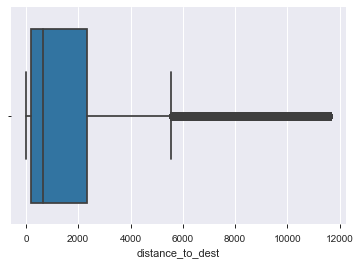

In [44]:
sns.boxplot(X['distance_to_dest'])

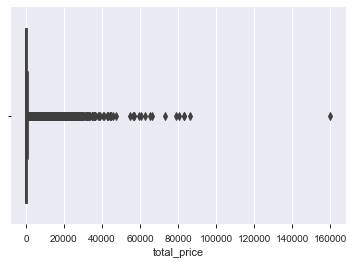

In [48]:
sns.boxplot(X['total_price'])

In [19]:
from scipy.special import boxcox1p, boxcox
import scipy.stats as stats

In [25]:
df3 = df_model[['total_price','distance_to_dest']]+1

In [26]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')
pt.fit(df3) 

PowerTransformer(copy=True, method='box-cox', standardize=True)

In [27]:
pt.lambdas_

array([-0.16220709,  0.14107405])

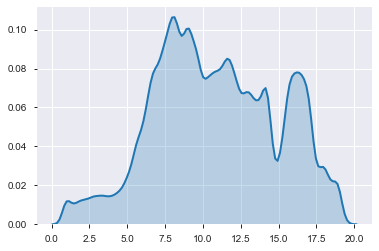

In [28]:
sns.distplot(boxcox1p(list(df3['distance_to_dest']),0.14107405),hist=False,kde_kws={'shade':3,'linewidth':2})

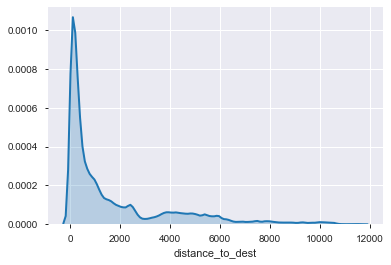

In [30]:
sns.distplot(df3['distance_to_dest'],hist=False,kde_kws={'shade':3,'linewidth':2})

# Treating outliers

In [32]:
df_model['total_price'] = boxcox1p(list(df_model['total_price']),-0.16220709)

df_model.loc[df_model.total_price > df_model.total_price.quantile(0.99), 'total_price'] = df_model.total_price.quantile(0.99)
df_model.loc[df_model.total_price < df_model.total_price.quantile(0.01), 'total_price'] = df_model.total_price.quantile(0.01)


In [33]:
df_model['distance_to_dest'] = boxcox1p(list(df_model['distance_to_dest']),0.14107405)

df_model.loc[df_model.distance_to_dest > df_model.distance_to_dest.quantile(0.99), 'distance_to_dest'] = df_model.distance_to_dest.quantile(0.99)
df_model.loc[df_model.distance_to_dest < df_model.distance_to_dest.quantile(0.01), 'distance_to_dest'] = df_model.distance_to_dest.quantile(0.01)


In [34]:
df_model.to_csv('df_model.csv')

In [1]:
import pandas as pd
df_model = pd.read_csv('df_model.csv')

In [5]:
df_model.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'distance_to_dest',
       'location_score2', 'listing_review_score', 'listing_position',
       'user_country_id', 'site_id', 'timestamp', 'listing_country_id',
       'listing_id', 'listing_stars', 'is_brand', 'location_score1',
       'log_historical_price', 'total_price', 'has_promotion',
       'destination_id', 'length_of_stay', 'booking_window', 'num_adults',
       'num_kids', 'num_rooms', 'stay_on_saturday', 'random_sort', 'clicked',
       'booked', 'num_total', 'price_usd_corr', 'search_id', 'weekday',
       'month'],
      dtype='object')

In [2]:
df_model['location_score1'] = df_model['location_score1'].astype('category')
df_model['listing_review_score'] = df_model['listing_review_score'].astype('category')
df_model['listing_stars'] = df_model['listing_stars'].astype('category')
df_model['is_brand'] = df_model['is_brand'].astype('category')
df_model['has_promotion'] = df_model['has_promotion'].astype('category')
df_model['stay_on_saturday'] = df_model['stay_on_saturday'].astype('category')
df_model['clicked'] = df_model['clicked'].astype('category')

In [8]:
X = df_model.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','booked','num_kids','num_adults','timestamp','clicked'],axis=1)
%time X = pd.get_dummies(X,drop_first=True)
y = df_model['booked']

CPU times: user 9.16 s, sys: 1.37 s, total: 10.5 s
Wall time: 11.1 s


# Applying Logistic Regression

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
%time lr.fit(X_train,Y_train)
%time lr.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 26.5 s, sys: 1.44 s, total: 28 s
Wall time: 30.4 s
CPU times: user 736 ms, sys: 328 ms, total: 1.06 s
Wall time: 635 ms


0.9722246205329712

In [46]:
from sklearn import metrics
#Mostly our purpose is to reduce the FN and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(lr.predict_proba(X_test))
threshold_list = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel

Our recalling accuracy is 0.96
Our accuracy is 0.17
Our f1_score is 0.06
Our precision_score is 0.03


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[ 94273 566962]
 [   674  18134]]

******** For i = 0.02 ******
Our recalling accuracy is 0.85
Our accuracy is 0.42
Our f1_score is 0.07
Our precision_score is 0.04
[[268446 392789]
 [  2822  15986]]

******** For i = 0.03 ******
Our recalling accuracy is 0.70
Our accuracy is 0.61
Our f1_score is 0.09
Our precision_score is 0.05
[[402535 258700]
 [  5624  13184]]

******** For i = 0.04 ******
Our recalling accuracy is 0.54
Our accuracy is 0.74
Our f1_score is 0.10
Our precision_score is 0.06
[[493375 167860]
 [  8676  10132]]

******** For i = 0.05 ******
Our recalling accuracy is 0.39
Our accuracy is 0.83
Our f1_score is 0.11
Our precision_score is 0.06
[[553772 107463]
 [ 11493   7315]]

******** For i = 0.06 ******
Our recalling accuracy is 0.27
Our accuracy is 0.88
Our f1_score is 0.11
Our precision_score is 0.07
[[593107  68128]
 [ 13692   5116]]

******** For i = 0.07 ******
Our recalling accuracy is 0.19
Our accuracy is 0.91
Our f1_score is 0.11
Our precision_score is 0.08
[[61

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Our recalling accuracy is 0.00
Our accuracy is 0.97
Our f1_score is 0.00
Our precision_score is 0.00
[[661235      0]
 [ 18808      0]]


# Applying SMOTE

In [10]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 123) 
%time X_train_res, y_train_res = sm.fit_sample(X_train, Y_train.ravel())   

Using TensorFlow backend.


CPU times: user 55.9 s, sys: 41.8 s, total: 1min 37s
Wall time: 1min 49s


In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
%time lr.fit(X_train_res,y_train_res)
%time lr.score(X_train_res,y_train_res)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 3min 57s, sys: 20.2 s, total: 4min 17s
Wall time: 4min 36s
CPU times: user 6.07 s, sys: 11.7 s, total: 17.8 s
Wall time: 20.4 s


0.7602998524656899

In [12]:
from sklearn import metrics
#Mostly our purpose is to reduce the FN and FP and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(lr.predict_proba(X_test))
threshold_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel

Our recalling accuracy is 1.00
Our accuracy is 0.05
Our f1_score is 0.05
Our precision_score is 0.03


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[ 14916 646319]
 [     8  18800]]

******** For i = 0.05 ******
Our recalling accuracy is 0.99
Our accuracy is 0.16
Our f1_score is 0.06
Our precision_score is 0.03
[[ 91931 569304]
 [   152  18656]]

******** For i = 0.1 ******
Our recalling accuracy is 0.98
Our accuracy is 0.28
Our f1_score is 0.07
Our precision_score is 0.04
[[168802 492433]
 [   467  18341]]

******** For i = 0.2 ******
Our recalling accuracy is 0.93
Our accuracy is 0.45
Our f1_score is 0.09
Our precision_score is 0.04
[[289196 372039]
 [  1346  17462]]

******** For i = 0.3 ******
Our recalling accuracy is 0.88
Our accuracy is 0.56
Our f1_score is 0.10
Our precision_score is 0.05
[[367123 294112]
 [  2260  16548]]

******** For i = 0.4 ******
Our recalling accuracy is 0.83
Our accuracy is 0.65
Our f1_score is 0.12
Our precision_score is 0.06
[[424846 236389]
 [  3124  15684]]

******** For i = 0.45 ******
Our recalling accuracy is 0.81
Our accuracy is 0.68
Our f1_score is 0.12
Our precision_score is 0.07
[[449280

# Applying class weight balanced

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
%time lr.fit(X_train,Y_train)
%time lr.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 2min 25s, sys: 16.3 s, total: 2min 41s
Wall time: 2min 52s
CPU times: user 4.4 s, sys: 5.67 s, total: 10.1 s
Wall time: 11.4 s


0.7097408879071571

In [14]:
from sklearn import metrics
#Mostly our purpose is to reduce the FN and FP and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(lr.predict_proba(X_test))
threshold_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel

Our recalling accuracy is 1.00
Our accuracy is 0.03
Our f1_score is 0.05
Our precision_score is 0.03


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[  2444 658791]
 [     3  18805]]

******** For i = 0.05 ******
Our recalling accuracy is 1.00
Our accuracy is 0.12
Our f1_score is 0.06
Our precision_score is 0.03
[[ 62674 598561]
 [    78  18730]]

******** For i = 0.1 ******
Our recalling accuracy is 0.99
Our accuracy is 0.20
Our f1_score is 0.06
Our precision_score is 0.03
[[120655 540580]
 [   242  18566]]

******** For i = 0.2 ******
Our recalling accuracy is 0.95
Our accuracy is 0.39
Our f1_score is 0.08
Our precision_score is 0.04
[[247501 413734]
 [   968  17840]]

******** For i = 0.3 ******
Our recalling accuracy is 0.90
Our accuracy is 0.53
Our f1_score is 0.10
Our precision_score is 0.05
[[342367 318868]
 [  1925  16883]]

******** For i = 0.4 ******
Our recalling accuracy is 0.85
Our accuracy is 0.63
Our f1_score is 0.11
Our precision_score is 0.06
[[411485 249750]
 [  2895  15913]]

******** For i = 0.45 ******
Our recalling accuracy is 0.82
Our accuracy is 0.67
Our f1_score is 0.12
Our precision_score is 0.06
[[440514

In [17]:
prob_y_4 = lr.predict_proba(X_test)
prob_y_4 = [p[1] for p in prob_y_4]
print( metrics.roc_auc_score(Y_test, prob_y_4) )

0.819143154838736


In [36]:
# Applying Random forest SMOTE

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=4,oob_score=True,n_jobs=-1,random_state=123)
%time rfc.fit(X_train_res,y_train_res)
%time rfc.score(X_train_res,y_train_res)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


CPU times: user 2min 34s, sys: 52.3 s, total: 3min 27s
Wall time: 2min 21s
CPU times: user 13.1 s, sys: 16.7 s, total: 29.8 s
Wall time: 31 s


0.8825578923077322

In [19]:
from sklearn import metrics
#Mostly our purpose is to reduce the FP and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(rfc.predict_proba(X_test))
threshold_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.5,0.55,0.6]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel

Our recalling accuracy is 1.00
Our accuracy is 0.03
Our f1_score is 0.05
Our precision_score is 0.03


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[     0 661235]
 [     0  18808]]

******** For i = 0.05 ******
Our recalling accuracy is 1.00
Our accuracy is 0.03
Our f1_score is 0.05
Our precision_score is 0.03
[[     0 661235]
 [     0  18808]]

******** For i = 0.1 ******
Our recalling accuracy is 1.00
Our accuracy is 0.03
Our f1_score is 0.05
Our precision_score is 0.03
[[     0 661235]
 [     0  18808]]

******** For i = 0.2 ******
Our recalling accuracy is 1.00
Our accuracy is 0.03
Our f1_score is 0.05
Our precision_score is 0.03
[[  2812 658423]
 [     7  18801]]

******** For i = 0.3 ******
Our recalling accuracy is 0.96
Our accuracy is 0.16
Our f1_score is 0.06
Our precision_score is 0.03
[[ 87683 573552]
 [   740  18068]]

******** For i = 0.4 ******
Our recalling accuracy is 0.74
Our accuracy is 0.55
Our f1_score is 0.08
Our precision_score is 0.04
[[357963 303272]
 [  4934  13874]]

******** For i = 0.41 ******
Our recalling accuracy is 0.70
Our accuracy is 0.59
Our f1_score is 0.09
Our precision_score is 0.05
[[385504

In [21]:
prob_y_4 = rfc.predict_proba(X_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(metrics.roc_auc_score(Y_test, prob_y_4))

0.6968344521725982


# separating the clicked==1 data separately

In [3]:
df_mod = df_model[df_model['clicked']==1]

In [4]:
X = df_mod.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','booked','num_kids','num_adults','timestamp','clicked'],axis=1)
%time X = pd.get_dummies(X,drop_first=True)
y = df_mod['booked']

CPU times: user 379 ms, sys: 46.2 ms, total: 426 ms
Wall time: 429 ms


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=123)

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
%time lr.fit(X_train,Y_train)
%time lr.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.17 s, sys: 239 ms, total: 1.41 s
Wall time: 1.63 s
CPU times: user 121 ms, sys: 64.5 ms, total: 186 ms
Wall time: 156 ms


0.6311652389890067

In [31]:
from sklearn import metrics
#Mostly our purpose is to reduce the FN and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(lr.predict_proba(X_test))
threshold_list = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    1 11363]
 [    0 19005]]

******** For i = 0.02 ******


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel

Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    1 11363]
 [    0 19005]]

******** For i = 0.03 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    1 11363]
 [    1 19004]]

******** For i = 0.04 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    1 11363]
 [    1 19004]]

******** For i = 0.05 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    3 11361]
 [    1 19004]]

******** For i = 0.06 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    5 11359]
 [    1 19004]]

******** For i = 0.07 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    5 11359]
 [    2 19003]]

******** For i = 0.08 ******
Our recalling accuracy is 1.

In [32]:
prob_y_4 = lr.predict_proba(X_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(metrics.roc_auc_score(Y_test, prob_y_4))

0.599868548273806


In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
%time lr.fit(X_train,Y_train)
%time lr.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 9.87 s, sys: 349 ms, total: 10.2 s
Wall time: 10.9 s
CPU times: user 144 ms, sys: 99.8 ms, total: 243 ms
Wall time: 273 ms


0.8584835099702234

In [35]:
from sklearn import metrics
#Mostly our purpose is to reduce the FN and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(lr.predict_proba(X_test))
threshold_list = [0.01,0.05,0.1,0.15,0.2,0.22,0.24,0.25,0.27,0.28,0.3,0.4,0.5,0.6,0.7]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[   39 11325]
 [    1 19004]]

******** For i = 0.05 ******
Our recalling accuracy is 0.99

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel


Our accuracy is 0.71
Our f1_score is 0.81
Our precision_score is 0.68
[[ 2671  8693]
 [  126 18879]]

******** For i = 0.1 ******
Our recalling accuracy is 0.97
Our accuracy is 0.83
Our f1_score is 0.87
Our precision_score is 0.80
[[ 6695  4669]
 [  642 18363]]

******** For i = 0.15 ******
Our recalling accuracy is 0.95
Our accuracy is 0.86
Our f1_score is 0.89
Our precision_score is 0.84
[[ 8021  3343]
 [  977 18028]]

******** For i = 0.2 ******
Our recalling accuracy is 0.94
Our accuracy is 0.86
Our f1_score is 0.90
Our precision_score is 0.85
[[ 8245  3119]
 [ 1072 17933]]

******** For i = 0.22 ******
Our recalling accuracy is 0.94
Our accuracy is 0.86
Our f1_score is 0.90
Our precision_score is 0.85
[[ 8256  3108]
 [ 1080 17925]]

******** For i = 0.24 ******
Our recalling accuracy is 0.94
Our accuracy is 0.86
Our f1_score is 0.90
Our precision_score is 0.85
[[ 8263  3101]
 [ 1081 17924]]

******** For i = 0.25 ******
Our recalling accuracy is 0.94
Our accuracy is 0.86
Our f1_s

In [36]:
prob_y_4 = lr.predict_proba(X_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(metrics.roc_auc_score(Y_test, prob_y_4))

0.8753478609021266


In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=8,oob_score=True,n_jobs=-1,random_state=123)
%time rfc.fit(X_train,Y_train)
%time rfc.score(X_train,Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


CPU times: user 2.34 s, sys: 259 ms, total: 2.6 s
Wall time: 2.28 s
CPU times: user 253 ms, sys: 133 ms, total: 386 ms
Wall time: 404 ms


0.8240640126444729

In [16]:
from sklearn import metrics
#Mostly our purpose is to reduce the FP and according to that we need to partition the data and choose the percentages
pred_proba_df = pd.DataFrame(rfc.predict_proba(X_test))
threshold_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.7]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    recall_accuracy = metrics.recall_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    f1score = metrics.f1_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    precisionscore = metrics.precision_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    
    print('Our recalling accuracy is {:.2f}'.format(recall_accuracy))
    print('Our accuracy is {:.2f}'.format(accuracy))
    print('Our f1_score is {:.2f}'.format(f1score))
    print('Our precision_score is {:.2f}'.format(precisionscore))
    print(metrics.confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.01 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    0 11364]
 [    0 19005]]

******** For i = 0.05 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
//anaconda3/lib/python3.7/site-packages/ipykernel

[[    0 11364]
 [    0 19005]]

******** For i = 0.1 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[    3 11361]
 [    0 19005]]

******** For i = 0.2 ******
Our recalling accuracy is 1.00
Our accuracy is 0.63
Our f1_score is 0.77
Our precision_score is 0.63
[[  164 11200]
 [    6 18999]]

******** For i = 0.3 ******
Our recalling accuracy is 1.00
Our accuracy is 0.67
Our f1_score is 0.79
Our precision_score is 0.65
[[ 1319 10045]
 [   53 18952]]

******** For i = 0.4 ******
Our recalling accuracy is 0.99
Our accuracy is 0.75
Our f1_score is 0.83
Our precision_score is 0.72
[[ 3904  7460]
 [  253 18752]]

******** For i = 0.5 ******
Our recalling accuracy is 0.96
Our accuracy is 0.83
Our f1_score is 0.87
Our precision_score is 0.80
[[ 6760  4604]
 [  670 18335]]

******** For i = 0.55 ******
Our recalling accuracy is 0.95
Our accuracy is 0.85
Our f1_score is 0.89
Our precision_score is 0.83
[[ 7780  3584]
 [  982 18023]]

*

In [17]:
prob_y_4 = rfc.predict_proba(X_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(metrics.roc_auc_score(Y_test, prob_y_4))

0.8663299020682325


In [21]:
pd.Series(rfc.feature_importances_,index=X_train.columns).sort_values(ascending=False)[:10]

random_sort             0.707290
total_price             0.052900
booking_window          0.048875
length_of_stay          0.033700
listing_position        0.032988
price_usd_corr          0.024671
log_historical_price    0.014628
num_total               0.013858
location_score2         0.012487
site_id                 0.008250
dtype: float64

# --------------------------------END-------------------------------------

In [61]:
X = df_pred.drop(['Unnamed: 0','Unnamed: 0.1','booked','num_kids','num_adults','timestamp','clicked'],axis=1)
%time X = pd.get_dummies(X,drop_first=True)
y = df_pred['booked']

CPU times: user 8.29 s, sys: 1.79 s, total: 10.1 s
Wall time: 10.9 s


# cut off taking as 0.59 f1_score of 0.89

In [71]:
pred_proba = pd.DataFrame(rfc.predict_proba(X))
df_pred['book_pred'] = pred_proba[1]
t = df_pred[df_pred['book_pred']<=0.59]
t['book_pred_fin'] = 0
r = df_pred[df_pred['book_pred']>0.59]
r['book_pred_fin'] = 1
df_pred = pd.concat([t,r])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

AttributeError: 'DataFrame' object has no attribute 'concat'

In [76]:
temp = df_pred[df_pred['book_pred_fin']==1]['search_id'].unique()
tmp = df_model[df_model['booked']==1]['search_id'].unique()

In [79]:
temp = df_pred[df_pred['book_pred_fin']==1]['search_id'].unique()
tmp = df_model[df_model['booked']==1]['search_id'].unique()

lst_nc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_nc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 89813
converted_users 62881
number of not converted people 28126
conversion rate 69.09468502422891


In [80]:
temp = df_pred[df_pred['book_pred_fin']==0]['search_id'].unique()
tmp = df_model[df_model['booked']==1]['search_id'].unique()

lst_ncc = []
for i in temp:
    if i in tmp:
        continue
    else:
        lst_ncc.append(i)
        
lst_nccc = []
for i in lst_ncc:
    if i in lst_nc:
        continue
    else:
        lst_nccc.append(i)
        
print('not_convereted_users_including_some_converted_users',len(temp))
print('converted_users',len(tmp))
nc = len(lst_nc)
c = len(tmp)
print('number of not converted people',len(lst_nccc))
print('conversion rate {}'.format(len(tmp)/(len(tmp)+len(lst_nc))*100))

not_convereted_users_including_some_converted_users 81383
converted_users 62881
number of not converted people 483
conversion rate 69.09468502422891


In [3]:
from itertools import combinations
L = [1, 2, 3, 4]
[",".join(map(str, comb)) for comb in combinations(L, 2)]

['1,2', '1,3', '1,4', '2,3', '2,4', '3,4']